<h2><center>ELIUD OMOLLO</center></h2>
<h2><center>IMAGE CAPTIONING USING KERAS</center></h2>

<b>In this project we will develop a model that takes in an image and generates captions that describe the image</b>

### Architecture

<table>
    <tr>      
        <td><img src="web/000000005652.jpg" alt="Cell Phone" style="width:128px;height:128px;"></td>
        <td><img src="web/arrow-alt-right.png" alt="Cell Phone" style="width:64px;height:64px;"></td>
        <td><img src="web/cnn-gru.jpg" alt="Cell Phone" style="width:640px;height:256px;"></td>
        <td><img src="web/arrow-alt-right.png" alt="Cell Phone" style="width:64px;height:64px;"></td>        
        <td style="text-align: left; font-weight: bold; ">a close up of a person holding a cell phone</td>
     </tr>
      <tr>       
        <td style="text-align: center; font-weight: bold; ">Image</td>
        <td></td>
         <td style="text-align: center; font-weight: bold; ">CNN + GRU</td>
        <td></td>        
        <td style="text-align: center; font-weight: bold; ">Caption</td>
     </tr>
</table>

### Imports

In [5]:
import tensorflow as tf 
from tensorflow.python.keras.applications import VGG19 
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model, load_model 
from tensorflow.python.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, Embedding, GRU  #layers
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger 
from tensorflow.python.keras.preprocessing.text import Tokenizer 
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from skimage.transform import resize 
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import numpy as np 
import pandas as pd 
from PIL import Image 
import matplotlib.pyplot as plt 
%matplotlib inline 
import json 
import os  
import pickle 

##### Utility Functions

In [6]:
class Utilities:
    
    def __init__(self):
        pass
    
    #Method to save file to disk using pickle
    def save_to_disk(self, data, filename):
        with open(filename, 'wb') as fp:
            pickle.dump(data, fp)
            print('Saved: %s' % filename)
    
    # load doc into memory
    def load_file(self, filename):
        with open(filename, mode='rb') as fn:
            data = pickle.load(fn)
        return data 

#### Preprocess Captions from COCO Dataset

In [7]:
class CocoData:
    '''
    Class to manage captions
    '''    
   
    def __init__(self, data_dir, annotation_path, save_path):
        self.data_dir = data_dir
        self.annotation_path = annotation_path
        self.save_path = save_path
        self.utils = Utilities()
    
    #read jason file and extract key "annotations"
    def _load_annotations(self):
        with open(self.annotation_path) as json_file: 
            raw = json.load(json_file) 
            annotations = raw['annotations'] 
        return annotations 
    
    #function to plot an image given the image id   
    def plot_image(self, img_id):
        image_path = str(img_id).zfill(12) +'.jpg' 
        image_path = os.path.join(self.data_dir, image_path) 
        img = Image.open(image_path)   
        img_array = np.array(img) 
        plt.imshow(img_array) 
        plt.show()
    
    def map_captions(self):
        caption_dict = {}        
        annotations = self._load_annotations()         
        image_ids = [int(fn.strip('0').split('.')[0]) for fn in  os.listdir(self.data_dir)]         
        
        for index, image_id in enumerate(image_ids):      
            for i in range(len(annotations)):        
                if annotations[i]['image_id'] == image_id:  
                    if image_id not in caption_dict: 
                        caption_dict[image_id] = []  
                    caption_dict[image_id].append(annotations[i]['caption']) 
            if  index % 500 == 0: #every 500 times..
                print('{} of {} completed'.format(index, len(image_ids))) 
        self.utils.save_to_disk(caption_dict, self.save_path)  
        print('Mapping Completed Successfully') 
        
    #load encoded files
    def load_captions(self, filename):
        return self.utils.load_file(filename) 

#### Encoding

In [8]:
class Encoder:
    
    def __init__(self):
        vgg19 = VGG19(include_top=True) # load  VGG19 Module
        encoder_input = vgg19.input # define input layer of the VGG19 model as input of our new model
        encoder_output = vgg19.get_layer(index=-2) # select the second to last later ('fc2)
        self.encoder_model = Model(inputs=encoder_input, outputs=encoder_output.output) # create encoder 
        encoder_output = self.encoder_model.get_layer(index=-1) #get last layer
        self.encoder_output_shape = encoder_output.output_shape #(None, 4096)
        self.utils = Utilities()
    
    #Given an image array, ecode the data to create the "thought vector"
    def encode_image(self, img_array): 
        image_array_reshape = img_array[np.newaxis,:, :, :] #change image shape from (224, 244,3) to (1, 224,244, 3)
        encodings = self.encoder_model.predict(x = image_array_reshape) # encode the image
        return encodings    #return shape (1, 4096)

    
    #Given a list dictionary of imageid and each imageid have 5+ caption, encode the dictionary
    
    def encode_images(self, image_dir,captions, enc_path, batch_size):
        
        #We are going to use the saved caption file to get the imae so that we the retain the order of 
        #captioning to encoding. The file system does not contain the mapping
        img_ids = [key for key in captions.keys()]   #get all the image ids
        file_names = [str(img_id).zfill(12) +'.jpg' for img_id in img_ids]     #create a filename of all the image_ids  
        imgs_path = [os.path.join(image_dir, fname) for fname in file_names] #create a full path name of all image ids          
           
        num_imgs = len(imgs_path)  #determine how many images we have to work with. We will put these throuth the econde

        #inputs
        encoder_input = self.encoder_model.input            #calling this to get the dimensions
        encoder_input_shape = K.int_shape(encoder_input)  # (None, 224, 224, 3) # shape of the input
        img_shape = encoder_input_shape[1:3]              # (224, 224)  #get the image shape


        #batches
        if batch_size > num_imgs:
            batch_size = num_imgs

        batch_shape = (batch_size,) + encoder_input_shape[1:]  #(batch_size, 224, 224, 3)    

        #outputs       
        encoder_output_shape_final = (num_imgs, self.encoder_output_shape[1]) #(num_imgs, 4096)

        #define containers
        batch_array = np.zeros(shape = batch_shape)    #numpy array of all images in an array. Input to encoder
        decoder_output_array = np.zeros(shape =encoder_output_shape_final ) # output of the encoder
        
        #Because the data is huge 18G!, we can't load it all to memory. So we will encode in batches i.e feed small 
        #chuncks of data to the system until the system processes it all
        
        batch_start = 0     #We are going at the beginning....
        while batch_start < num_imgs: #...and continue until we get to the end 
                        
            batch_end = batch_start + batch_size # the batch will beof size = batch_size
            if batch_end > num_imgs:  #if the last batch could be less that the batch_size..
                batch_end = num_imgs  #we make the last batch small. we could have used a modulus approach here 
                
            batch_window = batch_end - batch_start    #this the batch window
            print('batch_start = {}\tbatch_end = {} =======>'.format(batch_start, batch_end)) #print progress,to make 
            batch_imgs_path = imgs_path[batch_start:batch_end]        #we select files path from the batch

            for index, img_path in enumerate(batch_imgs_path):    #we go through each file..            
                curr_img = Image.open(img_path)    #...and open them
                img_array = np.array(curr_img)      # then we change into into numpy array. Future work: normalize    
                image_resized = resize(img_array, encoder_input_shape[1:4])   # resize image to (224, 224, 3)      
                assert image_resized.shape == encoder_input_shape[1:4]  #check if dimensions match
                batch_array[index] = image_resized #we add image array to the batch. When we have added all images ...
            batch_predictions = self.encoder_model.predict(x = batch_array[0: batch_window])  #we encode 
            decoder_output_array[batch_start : batch_end] = batch_predictions[0: batch_window] #the add that batch to array
            batch_start = batch_end        # and move to the next batch and repeat until all images are encoded
        self.utils.save_to_disk(data = decoder_output_array, filename = enc_path) #then we save to disk 
        print('Encoding complete') #as usual, we pat ourselves on the back

    #load encoded files
    def load_encoding(self, filename): #we find where we saved encoding
        return self.utils.load_file(filename) # ..and upload them. In future we will just use the saved encodings
        

### Tokenizing Captions

In [9]:
class TokenizeCaptions:
    '''
    Class to tokenize data
    '''
    
    def __init__(self, captions, num_words = 10000):
        self.captions = captions
        self.num_words = num_words
        self.token = self.create_tokenizer()
    
    #We want to add start and end markers to let the system know where the caption start and where they end
    #In this case we will use <captionstart> and '<captionend>'. 
    #We need unique charcters that are not in the vocabulary
        
    def add_markers(self):
        marked_caption_dict = {} # dictionary to hold the result
        for image_id, img_captions in self.captions.items():   # go through every image
            for img_caption in img_captions:                   #go through each caption
                if image_id not in marked_caption_dict:        #if we haven't added the imageid to the list
                    marked_caption_dict[image_id] = []         #we addd it and create a new list for the captions
                marked_caption_dict[image_id].append('<captionstart>' + img_caption + '<captionend>') #add markers
        return marked_caption_dict  #when done, we return the new array with markers
    
    #create a token using the captions. We will use this to tokenize data in future
    def create_tokenizer(self):        
        marked_caption_dict = self.add_markers() #add markers to the captions
        #flatten all captions into one list
        caption_list = [img_caption for caption in marked_caption_dict.values() for img_caption in caption]    
        tokenizer = Tokenizer(num_words = self.num_words)
        tokenizer.fit_on_texts(texts=caption_list) # train the tokenizer    
        return tokenizer #return tokenizeer
    
    #given a listen of tokens, return the words they represent
    #The tokenizer starts at 1. But since will be latter be padding with 0s, we let the system know..
    #a "0" should be replaced with "*"
    def tokens_to_sentences(self, list_of_tokens):        
        token_to_word = {0: '*'}      #represent '0' with '*'
        for key, value in self.token.word_index.items():      #go through words in the vocabulary          
            token_to_word[value] = key     # and swap key and value
        sentences = ' '. join([token_to_word[tkn] for tkn in list_of_tokens]) #then join them to make a sentence
        return sentences #return sentences

    def tokenize_captions(self):
        tokenized_caption_dict = {}
        token = self.token #Obtain token
        marked_captions = self.add_markers() #add start and end markers
        for image_id, img_captions in marked_captions.items():  #go through every caption...
            tokenized_captions = token.texts_to_sequences(img_captions) #and tokenize the caption
            tokenized_caption_dict[image_id] = tokenized_captions #save it back to the dictionary
        return tokenized_caption_dict            #return dictionary

### Batch Generation

This class generates a batch for size batch size. Each image has 5+ images. We will only one randomly a single image from the list of captions. Further studies can explore if there are better methods of selecting the caption or whether we should run the an image with every caption.

In [10]:
class BatchGenerator:
    
    '''
    This class generates batch of size batch_size. Each image has 5 or more captions
    '''
    def __init__(self, encoded_images, captions):
        self.encoded_images = encoded_images
        self.captions = captions
    
    #select a random caption out a list of list of 5+ captions[['caption1...caption5'],['caption1...caption5']]
    def assign_main_caption(self, ls_captions):
        selected_captions = []
        for caplist in ls_captions: #go through every list ['caption1...caption5']
            index = np.random.randint(0, len(caplist)) # select a random # between 0 and length of list
            random_caption = caplist[index] #use this number to select a random caption
            selected_captions.append(random_caption) #add the selected caption to the list
        return selected_captions
    
    #This generate_batch method will keep running until when we need it. 
    #We need to track how many step sizes we need to make an epoch
    def generate_batch(self, batch_size): 
         while True:
            #We will pick a random X # of integers wheres X = batch_size between 0 and # of images
            img_ids = np.random.randint(0,self.encoded_images.shape[0], size = batch_size)
            keys = [key for key in self.captions.keys()] #we get all the keys(img ids) from the captions
       
            
            curr_batch_imgs = self.encoded_images[img_ids]    #filter to get only the image_id in this batch        
            curr_batch_captions = [self.captions[keys[i]] for i in img_ids] #get caption list of list for batch         
            selected_captions = self.assign_main_caption(curr_batch_captions) #select a caption for each img
            
            
            #Decoder requires that all tokens have equal length. So will pad all the token to max lengh
            caption_lengths  = [len(caption_token) for caption_token in selected_captions]
            max_caption_len = np.max(caption_lengths) #get the length of each batch
            #use keras function to pad the captions to max length
            reshaped_caption_tokens = pad_sequences(sequences=selected_captions, 
                                                    maxlen=max_caption_len, 
                                                    padding='post',
                                                    truncating = 'post')
            #The decoder takes 3 inputs: The VGG19 output, tokens and time shifted version of the token
            decoder_input_captions = reshaped_caption_tokens[:, 0:-1] #we select the token
            decoder_output_captions = reshaped_caption_tokens[:, 1:] #tokens shifted by one
        
            #return the values as a dictionary
            x_data = {'encoder_input': curr_batch_imgs, 'decoder_input': decoder_input_captions}
            y_data = {'decoder_output':decoder_output_captions  }
            
            yield (x_data,  y_data)       

### Decoder

The decoder takes two inputs from the model:
<b>The embeddings: These are 128 

In [11]:
class Decoder:
    
    def __init__(self, encoder_model, units = 512, embedding_size = 128, num_words = 10000):
        self.encoder_output_dims = encoder_model.encoder_output_shape #get the dimension from encoder(None, 4096)
        self.units = units #dimensions of output
        self.embedding_size = embedding_size #embedding size
        self.num_words = num_words # number of words
        self.model = self.create_decoder() #create encorder when class is instantiated

    def create_decoder(self):        
        
        encoder_output_shape = self.encoder_output_dims[1] #4096        
        
        #define layers

        encoder_input = Input(shape=(encoder_output_shape,),name='encoder_input')
        encoder_input_map = Dense(units = self.units, activation='tanh', name='encoder_input_map')
        encoder_input_dense1 = Dense(units = self.units, activation='tanh', name='encoder_input_dense1')
        encoder_input_dense2 = Dense(units = self.units, activation='tanh', name='encoder_input_dense2')
        encoder_input_dense3 = Dense(units = self.units, activation='tanh', name='encoder_input_dense3')
        
        decoder_input = Input(shape=(None, ), name='decoder_input')        
        decoder_embedding = Embedding(input_dim= self.num_words, output_dim=self.embedding_size,name='decoder_embedding')
        decoder_gru1 = GRU(units = self.units, name='decoder_gru1', return_sequences=True)
        decoder_gru2 = GRU(units = self.units, name='decoder_gru2', return_sequences=True)        
        decoder_gru3 = GRU(units = self.units, name='decoder_gru3', return_sequences=True)
        decoder_gru4 = GRU(units = self.units, name='decoder_gru4', return_sequences=True) 
        decoder_dense = Dense(units = self.num_words,activation='linear', name='decoder_output')
        
        #Connect layers:
        dense = encoder_input_map(encoder_input)
        dense  = encoder_input_dense1(dense)
        dense  = encoder_input_dense2(dense)
        initial_state = encoder_input_dense3(dense)
        
        model = decoder_input
        model = decoder_embedding(model)
        model = decoder_gru1(model, initial_state=initial_state)
        model = decoder_gru2(model, initial_state=initial_state)        
        model = decoder_gru3(model, initial_state=initial_state) 
        model = decoder_gru4(model, initial_state=initial_state)
        decoder_output = decoder_dense(model)
        
        decoder_model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])

        return decoder_model 
 
    #wrapper that calculates the loss function. Note that keras only accepts y_true, y_pred as paramters
    def sparse_softmax_cross_entropy_with_logits(self, y_true, y_pred):   
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss_mean = tf.reduce_mean(loss)
        return loss_mean


In [12]:
TRAIN_CAPTIONS_PATH = 'data/annotations/captions_train2017.json'
TEST_CAPTIONS_PATH = 'data/annotations/captions_val2017.json'

TRAIN_PATH = 'data/train2017/'
TEST_PATH = 'data/test2017/'

SAVED_TRAIN_CAPTIONS = 'data/captions_train2017'
SAVED_TRAIN_ENCODINGS = 'encoding/train'
CHECKERPOINT_PATH  = 'checkpoints/decoder.keras'
LOG_DIR = './logs/'

CVS_LOGGER_FILE = 'cvs_log/decoder_model.csv'

EPOCHS = 50

In [13]:
%%time
batch_size= 100

coco = CocoData(data_dir= TRAIN_PATH, annotation_path= TRAIN_CAPTIONS_PATH, save_path= SAVED_TRAIN_CAPTIONS)
#check to see if we have mapped the captions already and load them or create them:
if os.path.isfile(SAVED_TRAIN_CAPTIONS):
    captions_train = coco.load_captions(SAVED_TRAIN_CAPTIONS)
else:
    map_captions()
    captions_train = coco.load_captions(SAVED_TRAIN_CAPTIONS)

tokenize = TokenizeCaptions(captions_train) 
tokenized_captions = tokenize.tokenize_captions() #tokenize data

encoder = Encoder()
#check to see if we have encoded files already and load them or create them:
if os.path.isfile(SAVED_TRAIN_ENCODINGS):
    encoded_images = encoder.load_encoding(SAVED_TRAIN_ENCODINGS)
else:
    encoder.encode_images(image_dir= TRAIN_PATH ,captions = captions_train, enc_path =SAVED_TRAIN_ENCODINGS, batch_size = 100)
    encoded_images = encoder.load_encoding(SAVED_TRAIN_ENCODINGS)


batch_gen = BatchGenerator(encoded_images, tokenized_captions) #create batch generator
generator = batch_gen.generate_batch(batch_size)


checkpoint_path = CHECKERPOINT_PATH  #path to save checkpoints
log_dir = LOG_DIR


decoder = Decoder(encoder_model= encoder) #define and create model
decoder_model = decoder.model

steps_per_epoch = 577
#We we will use RMSprop which provides an inbuilt learning rate decay
optimizer = RMSprop(lr=1e-4)




decoder_target = tf.placeholder(dtype=tf.int32, shape=(None, None))  #placeholder for the models target
decoder_model.compile(optimizer=optimizer,loss=decoder.sparse_softmax_cross_entropy_with_logits,
                      target_tensors=[decoder_target])
callback_checkpoint = ModelCheckpoint(filepath=checkpoint_path,monitor='loss', verbose=1) #save model if loss improves
callback_tensorboard = TensorBoard(log_dir=log_dir,
                                       histogram_freq=0,
                                       write_graph=False)
csv_logger = CSVLogger(filename= CVS_LOGGER_FILE) #save outputs to csv , we will pandas to plot

callbacks = [callback_checkpoint, callback_tensorboard, csv_logger] #keras requires callsback in a list

CPU times: user 21 s, sys: 4.16 s, total: 25.2 s
Wall time: 24.8 s


In [14]:
%%time
#if we already have the checkpont, we can load it, otherwise we train the model
if os.path.isfile(checkpoint_path):
    decoder_model.load_weights(checkpoint_path)
else:
    history = decoder_model.fit_generator(generator=generator,
                                    steps_per_epoch=steps_per_epoch,
                                    epochs=EPOCHS,
                                    callbacks=callbacks, verbose = 1)

CPU times: user 764 ms, sys: 288 ms, total: 1.05 s
Wall time: 1.02 s


In [15]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
encoder_input_map (Dense)       (None, 512)          2097664     encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_input_dense1 (Dense)    (None, 512)          262656      encoder_input_map[0][0]          
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_in

In [16]:
#decoder_model = load_model('models/decoder_model_30epochs.h5')

In [17]:
def make_prediction(img_id, data_dir, img_shape = (224, 224, 3), max_tokens=30, label = True, captions = captions_train):
    '''
    To select an image from not in the set, set label = False. This removes the bleau scores calculations
    '''
    
    if label:
        img_path = str(img_id).zfill(12) +'.jpg'
        img_path = os.path.join(data_dir, img_path)
    else:
        img_path = img_id
        
    curr_img = Image.open(img_path)
    img_array = np.array(curr_img)  
    
    #use skimage.transform function to resize image 
    image_resized = resize(image = img_array,output_shape= img_shape, mode= 'reflect')   
    assert image_resized.shape == img_shape   
    
    #Put the image through the encoder and get encoder out    
    encoder = Encoder()
    img_encoding = encoder.encode_image(img_array = image_resized)
    
    #define decoder_input
    
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int) 
    
    token_int = 2 
    token_end = 3
    output_text = []
    count_tokens = 0
    
    while token_int != token_end and count_tokens < max_tokens:       
        decoder_input_data[0, count_tokens] = token_int        
        x_data = {'encoder_input': img_encoding,'decoder_input': decoder_input_data} 
        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)        
        output_text.append(token_int)        
        count_tokens += 1    
   
    output_tokens = decoder_input_data[0]    
    output_text_words = tokenize.tokens_to_sentences(output_text[:-1])
    
    #display image
    plt.imshow(image_resized)
    plt.show()
    
    #This next block formats the data so the predictions and the captions have the same length
    #corpus_bleau requires that the prediction and the caption have the same lenth
    #get the longest length of the caption of the five caption
    #if the predictions are longer that the max length, we make all captions equal to the length
    # of prediction. We do this by adding space
    #if the captions are longer then we increase the length of the prediction by adding a space on the 
    #the predictions
    if label:
        #for i in range(5):        
        actual_values = captions_train[img_id]
        max_caption_len = np.max([len(v) for v in actual_values])        
        for actual_value in actual_values:
            if len([actual_value])< max_caption_len:    
                [actual_value].extend([' ' for l in range(max_caption_len - len([actual_value] ))])
            if len([actual_value])> len([output_text_words]):    
                [output_text_words].extend([' ' for l in range(len([actual_value]) - len([output_text_words]) )])        
            assert len([output_text_words]) == len([actual_value])
        for i, v in enumerate(actual_values):
            print('Caption {} : {}'.format(i,v))        
        print('\nPrediction:\t{}'.format(output_text_words))
        print('BLEU SCORES' )
        print('BLEU-1: %f' % corpus_bleu([actual_values], [output_text_words], weights=(1.0, 0, 0, 0)))
        print('BLEU-2: %f' % corpus_bleu([actual_values], [output_text_words], weights=(0.5, 0.5, 0, 0)))
        print('BLEU-3: %f' % corpus_bleu([actual_values], [output_text_words], weights=(0.3, 0.3, 0.3, 0)))
        print('BLEU-4: %f' % corpus_bleu([actual_values], [output_text_words], weights=(0.25, 0.25, 0.25, 0.25))) 
    else:
        print('\nPrediction:\t{}'.format(output_text_words))
        
    
     
    

### Predictions

##### Prediction from an image not in the sample

In [39]:

sample_img = 'testnew/image100.jpg'

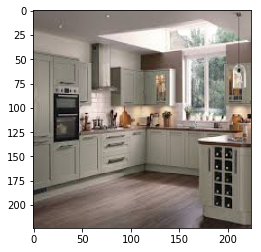


Prediction:	a kitchen with a stove and a stove


In [40]:
make_prediction(sample_img, data_dir = TRAIN_PATH, label=False)

##### Prediction from an image from the training set

### Predicting a random image

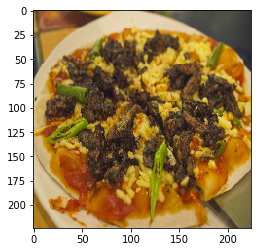

Caption 0 : a small pizza that is on a white plate
Caption 1 : Small pizza sitting on a white plate with different toppings on it. 
Caption 2 : The pizza is loaded with lots of toppings.
Caption 3 : A small personal sized pizza is shown on display.
Caption 4 : An exotic pizza sits on a plate, with cheese and bits of meat on top.

Prediction:	a pizza with a side of toppings on a plate
BLEU SCORES
BLEU-1: 1.000000
BLEU-2: 0.975305
BLEU-3: 0.929866
BLEU-4: 0.866377


In [20]:
#RANDONLY SELECT AN IMAGE FROM THE TRAIN SET TO EVALUATE SCORES AND PREDICTION
#An image can be manually selected by replacing randn_img_id with an image id in the set
#index = [key for key in captions_train.keys()]
#randn_img_id= int(np.random.choice(index, 1))
randn_img_id = 194
make_prediction(randn_img_id, data_dir = TRAIN_PATH)

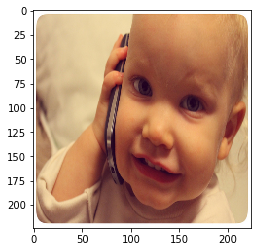

Caption 0 : A little baby with blue eyes talking on a phone.
Caption 1 : Small baby smiling at camera and talking on phone.
Caption 2 : A baby smiles and holds a cell phone up to its ear.
Caption 3 : a cute baby playing with a cell phone
Caption 4 : A smiling baby holding a cell phone up to ear.

Prediction:	a close up of a person holding a cell phone
BLEU SCORES
BLEU-1: 0.845856
BLEU-2: 0.775263
BLEU-3: 0.719608
BLEU-4: 0.639593


In [21]:
make_prediction(5652, data_dir = TRAIN_PATH)

#### Example of Caption that include intent and subjective terms
In this example, caption 4 is excessively labelled and tries to convey intent of the image. Lest we forget, Hammertime was also a reality TV show on the A&E Network

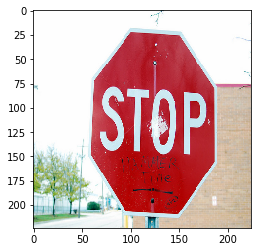

Caption 0 : A stop sign that has been written on with a black marker.
Caption 1 : Some graffiti is sprayed on a stop sign. 
Caption 2 : A stop sign with writings on it and a building in the background.
Caption 3 : A stop sign with the phrase "hammer time" written on it. 
Caption 4 : Stop sign near brick building and fenced area on treed street where someone has vandalized the sign to say "stop, hammer time" after MC Hammer's past music hit.

Prediction:	a stop sign with a stop sign on it
BLEU SCORES
BLEU-1: 0.813929
BLEU-2: 0.788879
BLEU-3: 0.759110
BLEU-4: 0.720384


In [22]:
make_prediction(5635, data_dir = TRAIN_PATH, label=True)

### Test performance vs validation perfomance
The model seems to perform very well on certain things. For example, the Giraffes. We will show here that when the model does well in one class, it tends to well for a new object in the same class. In this example, we provide a photo of a girrafe from a training set

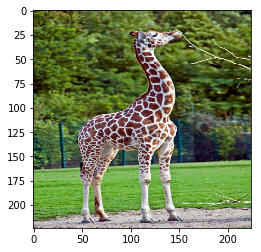

Caption 0 : A giraffe trying to eat leaves on the top of a branch
Caption 1 : Giraffe eating off a tree branch on an open field. 
Caption 2 : a giraffe nibbling on a branch of a tree
Caption 3 : A giraffe stands and puts a tree branch in its mouth.
Caption 4 : a griffa trying to eat leaves that has already been ate

Prediction:	a giraffe standing in a field with a tree in the background
BLEU SCORES
BLEU-1: 0.881356
BLEU-2: 0.826928
BLEU-3: 0.764121
BLEU-4: 0.659677


In [23]:
make_prediction(1282, data_dir = TRAIN_PATH)


<b>A random girrage from the internet that model has not seen

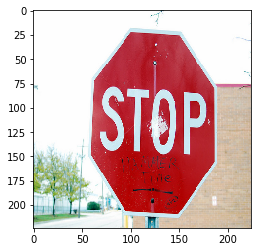

Caption 0 : A stop sign that has been written on with a black marker.
Caption 1 : Some graffiti is sprayed on a stop sign. 
Caption 2 : A stop sign with writings on it and a building in the background.
Caption 3 : A stop sign with the phrase "hammer time" written on it. 
Caption 4 : Stop sign near brick building and fenced area on treed street where someone has vandalized the sign to say "stop, hammer time" after MC Hammer's past music hit.

Prediction:	a stop sign with a stop sign on it
BLEU SCORES
BLEU-1: 0.813929
BLEU-2: 0.788879
BLEU-3: 0.759110
BLEU-4: 0.720384


In [24]:
make_prediction(5635, data_dir = TRAIN_PATH, label=True)

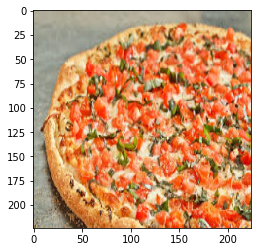


Prediction:	a pizza with cheese and cheese on a plate


In [25]:
make_prediction('testnew/tupac.jpg', data_dir = TRAIN_PATH, label=False)

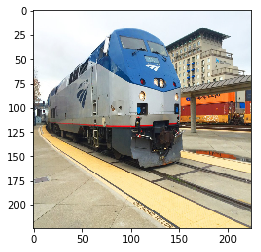


Prediction:	a train is on the tracks in the middle of the day


In [26]:
make_prediction('testnew/train.jpg', data_dir = TRAIN_PATH, label=False)

### Analysis

In [27]:
epoch_loss = pd.read_csv('cvs_log/decoder_model.csv')

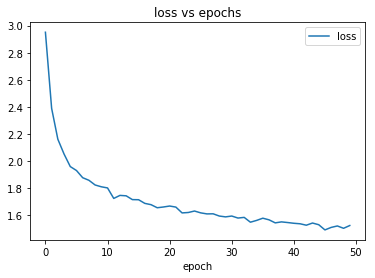

In [28]:
#Loss vs epochs
epoch_loss.plot(x = 'epoch', y ='loss', title='loss vs epochs')
plt.show()